# Imports

In [1]:
!source venv/bin/activate

/bin/bash: venv/bin/activate: No such file or directory


In [33]:
import math
import os
import os
from collections import Counter

import nltk
import nltk
import pandas as pd
import requests
import scipy.stats
import sklearn
import sklearn_crfsuite
import spacy
from bs4 import BeautifulSoup
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from spacy.matcher import Matcher
from spacy.symbols import ORTH
from spacy.tokenizer import Tokenizer

from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, recall_score, precision_score
import seaborn as sns

# Terminology Representation

## Define Tree Structure

In [3]:
class Node():
    def __init__(self, name = None):
        self.name = name
        self.points_to = dict()
        self.stored_value = None 
        
        self.visited = False #for searching

    def point_to_node(self, other_node):
        self.points_to[other_node.name] = other_node

    def is_leaf(self):
        return self.points_to == dict()
    
    def is_empty(self):
        return (self.stored_value is None)
    
    def list_children_names(self):
        return self.points_to.keys()
    
    def list_children(self):
        self.points_to.values()
    
    def list_values_in_children(self):
        stored_values = []
        
        if not self.is_empty():
            stored_values.append(self.stored_value)

        if self.is_leaf():
            return stored_values
        
        for node in self.points_to.values():
            stored_values.extend(
                node.list_values_in_children()
            )
        return stored_values
        

In [4]:

class TerminologyTree():
    def __init__(self, name = "", root = Node() ):
        self.name = name
        self.root = root

## Create Representation

In [5]:
def add_term_to_tree(term, tree):

    current_node = tree.root
    for word in term:
        #go to the next node

            # if there is no next node, create it
        if word not in current_node.points_to.keys():
            new_node = Node(word)
            current_node.points_to[word] = new_node
        else:
            new_node = current_node.points_to[word]
    
        current_node = new_node

    #now we are at the end of a path whose nodes spell the term

    #store the string in the end node
    current_node.stored_value = term


def fill_terminology_tree(term_list, tree):
    for term in term_list:
        add_term_to_tree(term, tree)
    return

# Article and Term Extraction

In [6]:
class ArticlesExtraction:
    def __init__(self, number=20, verbose=True, save_txt=True, save_pdf=True):
        self.number = number
        self.verbose = verbose
        self.save_txt = save_txt
        self.save_pdf = save_pdf

    def _get_links(self):
        if self.verbose:
            print(f'Getting the links for {self.number} articles...')
        mainpage = requests.get('https://as-botanicalstudies.springeropen.com/articles')
        mainsoup = BeautifulSoup(mainpage.text)
        links = ['https://as-botanicalstudies.springeropen.com' + x['href'] for x in
                 sum([x.findAll('a') for x in mainsoup.findAll('h3', class_="c-listing__title")], [])]
        return links[:self.number]

    def extract(self):
        extra = ['Availability of data and materials', 'Abbreviations', 'References', 'Acknowledgements',
                 'Funding', 'Author information', 'Ethics declarations', 'Additional information',
                 'Rights and permissions', 'About this article']
        links = self._get_links()
        pdf_links = []
        if self.verbose:
            print('Getting the texts...')
        texts = dict()
        for num, link in enumerate(links):
            if self.verbose:
                print(f'{num + 1}/{len(links)} links', end="\r")
            page = requests.get(link)
            pagecontent = BeautifulSoup(page.text)
            name = pagecontent.findAll('h1', class_="c-article-title")[0].text
            text = "\n".join(sum([list(map(lambda y: y.text, x.findAll('p'))) for x in pagecontent.findAll('section') if
                                  x.has_attr('data-title') and x['data-title'] not in extra], []))
            texts[name] = text
            pdf_link = [x.findAll('a') for x in pagecontent.findAll('div', class_="c-pdf-download u-clear-both")][0][0][
                'href']
            pdf_links.append(pdf_link)
        if self.save_txt:
            if self.verbose:
                print('Saving the articles in txt...')
            if not os.path.exists('articles'):
                os.mkdir('articles')
            for key, value in texts.items():
                with open(f"articles/{key.replace('/', '|')}.txt", 'w') as file:
                    file.write(value)
        if self.save_pdf:
            if self.verbose:
                print('Saving the articles in pdf...')
            if not os.path.exists('articles_pdf'):
                os.mkdir('articles_pdf')
            for (key, value), link in zip(texts.items(), pdf_links):
                pdf = requests.get('https:' + link, allow_redirects=True)
                open(f"articles_pdf/{key.replace('/', '|')}.pdf", 'wb').write(pdf.content)
        return texts

In [7]:
def custom_tokenizer(nlp = spacy.load("en_core_web_sm")):
    
    special_case = [{ORTH: "<bos>"}]
    nlp.tokenizer.add_special_case("<bos>", special_case)

    special_case = [{ORTH: "<eos>"}]
    nlp.tokenizer.add_special_case("<eos>", special_case)

    infixes = list([r"'s\b", r"(?<!\d)\.(?!\d)"]) +  nlp.Defaults.prefixes
    infix_re = spacy.util.compile_infix_regex(infixes)
    nlp.tokenizer.infix_finditer = infix_re.finditer
    
    return Tokenizer(nlp.vocab, infix_finditer=infix_re.finditer)
nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = custom_tokenizer(nlp)


In [8]:
class RuleBasedExtractor:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.matcher = Matcher(self.nlp.vocab)

    def extract(self, texts):
        all_terms = []
        self._add_rules()
        for num, text in enumerate(texts):
            doc = self.nlp(text)
            matches = self.matcher(doc)
            for match_id, start, end in matches:
                string_id = self.nlp.vocab.strings[match_id]
                span = doc[start:end]
                lemma = ' '.join([n.lemma_ for n in self.nlp(span.text.lower())])
                all_terms.append(lemma)

            print(f'{num + 1}/{len(texts)} texts processed', end="\r")
        return all_terms

    def _add_rules(self):
        noun_pattern = {"POS": {"IN": ["NOUN", "PROPN"]}}
        det_pattern = {"POS": {"IN": ["DET", "PRON"]}, "OP": "?"}
        pattern = [  #[{"POS": "NOUN"}, {"POS": "NOUN"}],
            [noun_pattern, noun_pattern],
            #[{"DEP": "compound"}, {"POS": "NOUN"}],
            [noun_pattern, {"POS": "ADP"}, noun_pattern],
            [{"POS": "ADJ", "OP": "+"}, noun_pattern],
            [noun_pattern, {"POS": "ADP"}, det_pattern, noun_pattern],
            [det_pattern, {"POS": "ADJ"}, {"POS": "CCONJ"}, {"POS": "ADJ"}, noun_pattern],
        ]
        self.matcher.add("terms", pattern)

# Annotator

In [9]:
class Annotator:
    tagging = dict()
    def __init__(self):        
        self.nlp = spacy.load('en_core_web_sm')

    def _longest_term(self, position, word_list, tree):
        current_node  = tree.root
        term = []

        while True:
            try:
                word = word_list[position]
                current_node = current_node.points_to[word]
                if not current_node.is_empty(): 
                    aux_term = current_node.stored_value
                    if len(aux_term) > len(term): term = aux_term
                position += 1
            except:
                break
        
        return term



    def annotate(self, tree, text):
        """"
        returns a list of tuples (word, tag)
        """
        tagging = dict()
        position = 0
        nlp_text = self.nlp(text)
        word_list = [token.text for token in nlp_text]

        def put_tag(position, tag):
            tagging[str(position)]= tag
            return None

        while position < len(word_list):
            #find the longest term appearing in the text at this position
            term = self._longest_term(position, word_list, tree)
            
            length = len(term)

            if length == 0: # no term was found
                put_tag(position, "O")
                position += 1
            else:
                put_tag(position, "B") # beginning of term
                for i in range(length-1):
                    put_tag(position + i +1, "I") #inside of term
                position += length

        text_tags = [
            (token.text, token.pos_, tagging[str(position)])
            for position, token in enumerate(nlp_text)
        ]

        return text_tags



In [10]:
class SequenceClassifier:
    def __init__(self):
        pass

    def word2features(self, sent, i):
        word = sent[i][0]
        postag = sent[i][1]

        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
            'postag': postag,
            'postag[:2]': postag[:2],
        }
        if i > 0:
            word1 = sent[i - 1][0]
            postag1 = sent[i - 1][1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
                '-1:postag': postag1,
                '-1:postag[:2]': postag1[:2],
            })
        else:
            features['BOS'] = True

        if i < len(sent) - 1:
            word1 = sent[i + 1][0]
            postag1 = sent[i + 1][1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
                '+1:postag': postag1,
                '+1:postag[:2]': postag1[:2],
            })
        else:
            features['EOS'] = True

        return features

    def sent2features(self, sent):
        return [self.word2features(sent, i) for i in range(len(sent))]

    def sent2labels(self, sent):
        return [label for token, postag, label in sent]

    def sent2tokens(self, sent):
        return [token for token, postag, label in sent]

    def convert_corpus(self, sents):
        X = [self.sent2features(s) for s in sents]
        y = [self.sent2labels(s) for s in sents]
        return X, y

    def fit(self, X_train, y_train):

        crf = sklearn_crfsuite.CRF(
            algorithm='lbfgs',
            c1=0.1,
            c2=0.1,
            max_iterations=100,
            all_possible_transitions=True)
        crf.fit(X_train, y_train)
        return crf


# Experiments

## Extract Articles

In [11]:
artextr = ArticlesExtraction(25, save_txt=False, save_pdf=False)
articles = artextr.extract()
texts = [x for x in list(articles.values())]

Getting the links for 25 articles...
Getting the texts...


## Create Terminology

### Extract Terms

In [12]:
r = RuleBasedExtractor()
all_t = r.extract(texts)

In [13]:
all_t

['tropical forest',
 'mature tropical forest',
 'many mature tropical forest',
 'ecological significance',
 'p stock',
 'stock as soil',
 'soil age',
 'tropical forest',
 'forest soil',
 'various form',
 'form of the fe',
 'al sesquioxides',
 'hedley fraction',
 'fraction of p',
 'p in soil',
 'ferralitic chronosequence',
 'incipient ferralitic chronosequence',
 'altitudinal series',
 'bench on green',
 'green island',
 'southeastern coast',
 'coast of taiwan',
 'limited amount',
 'exchangeable p.',
 'p. of the sesquioxide',
 'sesquioxide variable',
 'al crystallinities',
 'bench altitude',
 'soil age',
 'ferralisation trend',
 'bulk of the soil',
 'soil p',
 'extractable fraction',
 'residual extractable fraction',
 'low lability',
 'p fraction',
 'organic component',
 'component of the nahco3',
 'amorphous sesquioxide',
 'p fraction',
 'substantial proportion',
 'labile p',
 'aluminium complex',
 'progression of p',
 'p sequestration',
 'the chemical and mineralogical indicator',
 'c

In [14]:
popular_terms = Counter([x.lower() for x in all_t]).most_common(100000)
with open('popular_terms.txt', 'w') as file:
    for line in popular_terms:
        file.write(line[0] + '\n')

### Create Tree Representation for Terminology

In [15]:
tree = TerminologyTree()
terminology = [t.split(' ') for t in all_t] # terms converted from strings to lists of words  
fill_terminology_tree(terminology, tree)

## Annotate Text

In [16]:
%%time
anno = Annotator()
# tokenizer inside the class instead of split
annotations = [anno.annotate(tree, text) for text in texts]
annotations

CPU times: user 19.9 s, sys: 252 ms, total: 20.2 s
Wall time: 20.2 s


[[('Phosphorus', 'PROPN', 'O'),
  ('(', 'PUNCT', 'O'),
  ('P', 'NOUN', 'O'),
  (')', 'PUNCT', 'O'),
  ('is', 'AUX', 'O'),
  ('the', 'DET', 'O'),
  ('limiting', 'VERB', 'O'),
  ('nutrient', 'NOUN', 'O'),
  ('in', 'ADP', 'O'),
  ('many', 'ADJ', 'O'),
  ('mature', 'ADJ', 'O'),
  ('tropical', 'ADJ', 'O'),
  ('forests', 'NOUN', 'O'),
  ('.', 'PUNCT', 'O'),
  ('The', 'DET', 'O'),
  ('ecological', 'ADJ', 'B'),
  ('significance', 'NOUN', 'I'),
  ('of', 'ADP', 'O'),
  ('declining', 'VERB', 'O'),
  ('P', 'NOUN', 'O'),
  ('stocks', 'NOUN', 'O'),
  ('as', 'ADP', 'O'),
  ('soils', 'NOUN', 'O'),
  ('age', 'NOUN', 'O'),
  ('is', 'AUX', 'O'),
  ('exacerbated', 'VERB', 'O'),
  ('by', 'ADP', 'O'),
  ('much', 'ADJ', 'O'),
  ('of', 'ADP', 'O'),
  ('the', 'DET', 'O'),
  ('remaining', 'VERB', 'O'),
  ('P', 'NOUN', 'O'),
  ('being', 'AUX', 'O'),
  ('progressively', 'ADV', 'O'),
  ('sequestered', 'VERB', 'O'),
  ('.', 'PUNCT', 'O'),
  ('However', 'ADV', 'O'),
  (',', 'PUNCT', 'O'),
  ('the', 'DET', 'O'),
  ('

## Model

In [37]:
test = annotations[20:] # 5 articles
train = annotations[:20] # 20 articles

In [38]:
seq = SequenceClassifier()
X_train, y_train = seq.convert_corpus(train)
model = seq.fit(X_train, y_train)

In [39]:
labels = list(model.classes_)

In [40]:
X_test, y_test = seq.convert_corpus(test)
y_pred = model.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.9828660276415278

In [41]:
metrics.flat_recall_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.9827877263248486

In [42]:
metrics.flat_precision_score(y_test, y_pred,
 average='weighted', labels=labels)

0.9829653316832861

In [43]:
flat_y_test = []
flat_y_pred = []
for elem in y_test:
    flat_y_test.extend(elem)
for elem in y_pred:
    flat_y_pred.extend(elem)

In [44]:
from sklearn.metrics import classification_report
class_report = classification_report(y_true=flat_y_test, y_pred=flat_y_pred, labels=labels)
print(class_report)

              precision    recall  f1-score   support

           O       0.99      0.99      0.99     26899
           B       0.91      0.93      0.92      1503
           I       0.90      0.91      0.91      1809

    accuracy                           0.98     30211
   macro avg       0.93      0.95      0.94     30211
weighted avg       0.98      0.98      0.98     30211



[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

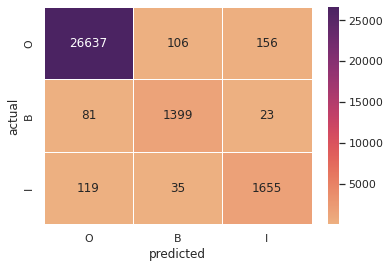

In [45]:
conf_mat = confusion_matrix(flat_y_test, flat_y_pred, labels=labels)
sns.set(font_scale=1)
x_axis_labels = labels
y_axis_labels = labels
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
matrix.set(xlabel='predicted', ylabel='actual')